In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


In [3]:
def load_data(path, rows = 300000):
    """
    Load the training data
    rows --> maximum number of rows to load from the dataset

    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.drop_duplicates()
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
    data.columns = ['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']
    
    return data[['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']]

def load_data_test(path, rows = 25000):
    """
    Load the testing data (HT clean and HT contaminated)
    rows --> maximum number of rows to load from the dataset
    
    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
    data.columns = ['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']
    # data = data.drop_duplicates()
    return data[['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']]

In [4]:
# Define number of rows to load from the dataset
num_of_splits = 2
Number_of_train_rows = num_of_splits*5000 
Number_of_test_rows = 100000  # This is only half of the overall test dataframe, since we append HT-clean to HT-contaminated


# Load the dataframes

# train_file_path  = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_training_data.txt'
# test_file_path   = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_testing_data.txt'
# trojan_file_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_trojan_data.txt'

trojan_name      =                                                                            'HT_c^100'
train_file_path  = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_c^100\my_training_data.txt'
edge_points_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_c^100\Edge_points.txt'
test_file_path   = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_c^100\my_testing_data.txt'
trojan_file_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_c^100\my_trojan_data.txt'


# Load train data
train_data = load_data(train_file_path, rows = Number_of_train_rows)
X_train = np.r_[train_data]
n_train_rows, n_train_columns = X_train.shape

# Load edge point data
edge_points = load_data(edge_points_path, rows = 100000)
edge_points = np.r_[edge_points]
edge_points_rows, edge_points_columns = edge_points.shape

# Load some regular novel observations
test_data = load_data_test(test_file_path, rows = Number_of_test_rows)
X_test = np.r_[test_data]
n_test_rows, test_columns = X_test.shape

# Load some abnormal novel observations
trojan_data = load_data_test(trojan_file_path, rows = Number_of_test_rows)
X_outliers = np.r_[trojan_data]
n_outliers_rows, outliers_columns = X_outliers.shape

### Quick visualisation of the datapoints

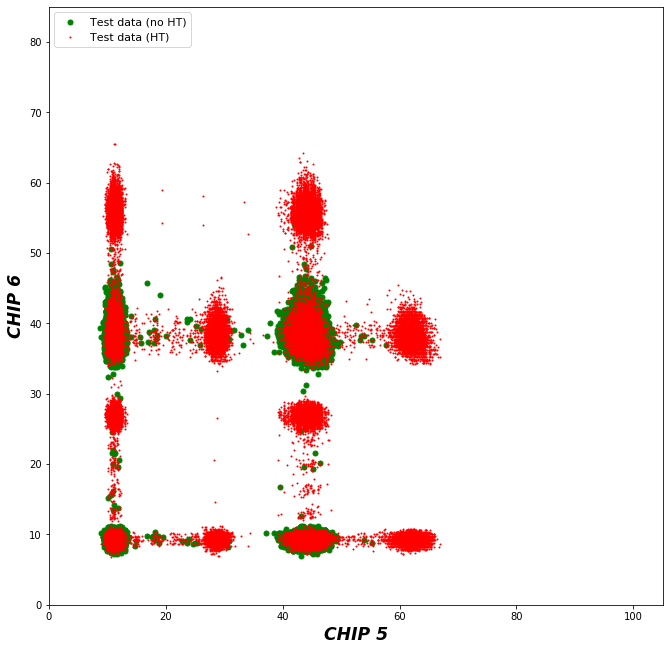

In [5]:
plt.figure(figsize=(11,11))

column1 = 5
column2 = 6

noHT = plt.scatter(X_test[:, column1], X_test[:, column2], c='green', s=25, edgecolors='green')
HT = plt.scatter(X_outliers[:, column1], X_outliers[:, column2], c='red', s=1, edgecolors='red')

plt.axis('tight')
plt.xlim((0, 105))
plt.ylim((0, 85))

plt.legend([noHT, HT], ["Test data (no HT)", "Test data (HT)"], loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))

# plt.xlabel(
#     "Errors train: %d/%d ; "
#     "Errors novel regular: %d/%d ; "
#     "Errors novel abnormal: %d/%d"
#     % (n_error_train, n_train_rows ,n_error_test, n_test_rows, n_error_outliers, n_outliers_rows))
plt.xlabel("CHIP {}".format(column1), fontsize='xx-large', fontstyle='oblique', fontweight='bold')
plt.ylabel("CHIP {}".format(column2), fontsize='xx-large', fontstyle='oblique', fontweight='bold')

plt.show()

#### Prepare the data

In [6]:
y_test = np.ones((Number_of_test_rows,1), dtype='int')
y_outliers = np.negative(np.ones((Number_of_test_rows,1), dtype='int'))
y_test_comined = np.vstack((y_test,y_outliers))
X_test_comined = np.vstack((X_test,X_outliers))
full_test_data = np.hstack((X_test_comined, y_test_comined))
np.random.shuffle(full_test_data)
y_test_comined = full_test_data[:,-1].reshape(int(Number_of_test_rows*2),1)
X_test_comined = full_test_data[:,0:-1]

print("Test data manipulation...")
print(y_test.shape,'  // HT clean test data label shape')
print(y_outliers.shape,'  // HT contaminated test data label shape')
print(y_test_comined.shape,'  // Combined test data label shape')
print()
print(X_test.shape,'  // HT clean test data feature shape')
print(X_outliers.shape,'  // HT contaminated test data feature shape')
print(full_test_data.shape,'  // Combined test data (feature + label) shape')

Test data manipulation...
(100000, 1)   // HT clean test data label shape
(100000, 1)   // HT contaminated test data label shape
(200000, 1)   // Combined test data label shape

(100000, 10)   // HT clean test data feature shape
(100000, 10)   // HT contaminated test data feature shape
(200000, 11)   // Combined test data (feature + label) shape


### Scaling the data..........update: actually worsened the results

In [7]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# #Scaling
# # Column_names = X.columns
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train =scaler.transform(X_train)
# X_test_comined = data=scaler.transform(X_test_comined)


In [8]:
x = datetime.datetime.now()
# trojan_name = 'HT3_3 - 4'


#Initiate all the files

Results_file = open("dump_RESULTS.txt", "a")
Results_file.write("\n\nNew occurence at: {}, Trojan name: {} \n\nkernel, nu,    gamma,   Accuracy, F1_score,  Recall,   Precision, No_Sup_Vec, TP,     FN,     FP,      TN\n\n".format(x, trojan_name))
# Results_file.write("\n\nNew occurence at: {}, Trojan name: {} \n\nkernel , nu   , gamma,   Accuracy,   F1_score,  Recall,  Precision,   No_Sup_Vec \n".format(x, trojan_name))
Results_file.close()

# nu_list_file =  open("nu_list_file.txt", "a")
# nu_list_file.write("\n\nNew occurence at: {}, Trojan name: {} \nnu_list = np.array([".format(x, trojan_name))
# nu_list_file.close()
# gamma_list_file =  open("gamma_list_file.txt", "a")
# gamma_list_file.write("\n\nNew occurence at: {}, Trojan name: {} \ngamma_list = np.array([".format(x, trojan_name))
# gamma_list_file.close()
F1_score_file =  open("_F1_scores.txt", "a")
F1_score_file.write("\n\nNew occurence at: {}, Trojan name: {} \nF1_score_list = np.array([".format(x, trojan_name))
F1_score_file.close()
# Accuracy_score_file =  open("Accuracy_score_file.txt", "a")
# Accuracy_score_file.write("\n\nNew occurence at: {}, Trojan name: {} \nAccuracy_score_list = np.array([".format(x, trojan_name))
# Accuracy_score_file.close()
# Recall_file =  open("Recall_file.txt", "a")
# Recall_file.write("\n\nNew occurence at: {}, Trojan name: {} \nRecall_list = np.array([".format(x, trojan_name))
# Recall_file.close()
# Precision_file =  open("Precision_file.txt", "a")
# Precision_file.write("\n\nNew occurence at: {}, Trojan name: {} \nPrecision_list = np.array([".format(x, trojan_name))
# Precision_file.close()
No_Sup_Vec_file =  open("_No_Support_Vectors.txt", "a")
No_Sup_Vec_file.write("\n\nNew occurence at: {}, Trojan name: {} \nNo_Support_Vectors = np.array([".format(x, trojan_name))
No_Sup_Vec_file.close()

In [9]:
# nu_list = np.arange(0.0001, 0.00350001, 0.0002)
# gamma_list = np.arange(0.001, 0.030, 0.002)

# nu_list = np.arange(0.005, 0.0160001, 0.0025)
# gamma_list = np.arange(0.001, 0.0110001, 0.0025)

nu_list    = np.arange(0.001, 0.030, 0.004)
gamma_list = np.arange(0.001, 0.030, 0.004)

# nu_list    = np.arange(0.002, 0.008, 0.002)
# gamma_list = np.arange(0.021, 0.029, 0.002)
# nu_list = [0.05]
# gamma_list = [0.02]
num_of_splits = 2
best_F1_score = 0
kf_train = KFold(n_splits=num_of_splits, shuffle=True, random_state=78)
kf_train.get_n_splits(X_train)
train_indexes = [ o for _ , o in kf_train.split(X_train)]

kf_test = KFold(n_splits=num_of_splits, shuffle=True, random_state=78)
kf_test.get_n_splits(X_test_comined)
test_indexes = [ o for _ , o in kf_test.split(X_test_comined)]

kernel = "rbf"
print("Beginning the training...\n")
for nu in nu_list:
    
#     nu_list_file =  open("nu_list_file.txt", "a")
#     nu_list_file.write("\n")
#     nu_list_file.close()
#     gamma_list_file =  open("gamma_list_file.txt", "a")
#     gamma_list_file.write("\n")
#     gamma_list_file.close()
    F1_score_file =  open("_F1_scores.txt", "a")
    F1_score_file.write("\n(")
    F1_score_file.close()
#     Accuracy_score_file =  open("Accuracy_score_file.txt", "a")
#     Accuracy_score_file.write("\n(")
#     Accuracy_score_file.close()
#     Recall_file =  open("Recall_file.txt", "a")
#     Recall_file.write("\n(")
#     Recall_file.close()
#     Precision_file =  open("Precision_file.txt", "a")
#     Precision_file.write("\n(")
#     Precision_file.close()
    No_Sup_Vec_file =  open("_No_Support_Vectors.txt", "a")
    No_Sup_Vec_file.write("\n(")
    No_Sup_Vec_file.close()
    
    for gamma in gamma_list:
        
        
        Precisions = np.array([])
        Recalls    = np.array([])
        F1_scores = np.array([])
        Accuracies = np.array([])
        num_of_support_vectors_list = np.array([])
        
        for trn_idx, tst_idx in zip(train_indexes, test_indexes): # Do KFold cross-validation
            
            ###################### # fit the model

            clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
            clf.fit(np.vstack((X_train[trn_idx,:], edge_points)))

            ###################### # predict

            y_pred_train = clf.predict(X_train)
            y_pred_test = clf.predict(X_test)
            y_pred_outliers = clf.predict(X_outliers)

            ###################### # store some values
            n_error_train = y_pred_train[y_pred_train == -1].size
            n_correct_test = y_pred_test[y_pred_test == 1].size
            n_error_test = y_pred_test[y_pred_test == -1].size
            n_correct_outliers = y_pred_outliers[y_pred_outliers == -1].size
            n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

            ###################### # calculate the metrics 
            TP = n_correct_test
            FN = n_error_test
            FP = n_error_outliers
            TN = n_correct_outliers

    
            y_pred_combined = clf.predict(X_test_comined[tst_idx,:]).reshape(-1,1)

            Precision = precision_score(y_test_comined[tst_idx,:], y_pred_combined)
            Recall    = recall_score(y_test_comined[tst_idx,:], y_pred_combined)
            F1_score  = f1_score(y_test_comined[tst_idx,:], y_pred_combined)
            Accuracy  = accuracy_score(y_test_comined[tst_idx,:], y_pred_combined)
            num_of_support_vectors = clf.support_vectors_.shape[0]
            
            
            # Append values in arrays to take the average at a later step
            Precisions = np.append(Precisions, Precision)
            Recalls    = np.append(Recalls, Recall)
            F1_scores  = np.append(F1_scores, F1_score)
            Accuracies = np.append(Accuracies, Accuracy)
            num_of_support_vectors_list = np.append(num_of_support_vectors_list, num_of_support_vectors)
        
        ###################### # take the average of metrics generated from KFold cross-validation
        Precision = round(np.mean(Precisions),5)
        Recall    = round(np.mean(Recalls),5)
        F1_score  = round(np.mean(F1_scores),5)
        Accuracy  = round(np.mean(Accuracies),5)
        num_of_support_vectors = round(np.mean(num_of_support_vectors_list))
        ###################### # store the parameters for the best F1 score
        
        if F1_score > best_F1_score:
            nu_best = nu
            gamma_best = gamma
            best_F1_score = F1_score
        
        
        TN, FP, FN, TP = confusion_matrix(y_test_comined, clf.predict(X_test_comined).reshape(-1,1)).ravel()

        
        ###################### # Record the generated data for later use
        Results_file = open("dump_RESULTS.txt", "a")
        Results_file.write("{}  , {}  , {}  ,  {}  , {}  , {}  , {}  , {}  ,  {}   , {}  , {}  , {}\n".format(kernel, round(nu, 5),
                                                                                                              round(gamma, 5), Accuracy,
                                                                                                              F1_score, Recall, Precision,
                                                                                                              num_of_support_vectors,
                                                                                                              TP, FN, FP, TN))

        
#         Results_file.close()
        
#         nu_list_file =  open("nu_list_file.txt", "a")
#         nu_list_file.write(", {}".format(round(nu, 5)))
#         nu_list_file.close()
#         gamma_list_file =  open("gamma_list_file.txt", "a")
#         gamma_list_file.write(", {}".format(round(gamma, 5)))
#         gamma_list_file.close()        
        F1_score_file =  open("_F1_scores.txt", "a")
        F1_score_file.write(", {}".format(F1_score))
        F1_score_file.close()
#         Accuracy_score_file =  open("Accuracy_score_file.txt", "a")
#         Accuracy_score_file.write(", {}".format(Accuracy))
#         Accuracy_score_file.close()
#         Recall_file =  open("Recall_file.txt", "a")
#         Recall_file.write(", {}".format(Recall))
#         Recall_file.close()
#         Precision_file =  open("Precision_file.txt", "a")
#         Precision_file.write(", {}".format(Precision))
#         Precision_file.close()
        No_Sup_Vec_file =  open("_No_Support_Vectors.txt", "a")
        No_Sup_Vec_file.write(", {}".format(num_of_support_vectors))
        No_Sup_Vec_file.close()
        print(" ... ")
        
        
        
        
    F1_score_file =  open("_F1_scores.txt", "a")
    F1_score_file.write("),")
    F1_score_file.close()
#     Accuracy_score_file =  open("Accuracy_score_file.txt", "a")
#     Accuracy_score_file.write("),")
#     Accuracy_score_file.close()
#     Recall_file =  open("Recall_file.txt", "a")
#     Recall_file.write("),")
#     Recall_file.close()
#     Precision_file =  open("Precision_file.txt", "a")
#     Precision_file.write("),")
#     Precision_file.close()
    No_Sup_Vec_file =  open("_No_Support_Vectors.txt", "a")
    No_Sup_Vec_file.write("),")
    No_Sup_Vec_file.close()        
        
    print("\n")
    
# nu_list_file =  open("nu_list_file.txt", "a")
# nu_list_file.write("])")
# nu_list_file.close()
# gamma_list_file =  open("gamma_list_file.txt", "a")
# gamma_list_file.write("])")
# gamma_list_file.close()
F1_score_file =  open("_F1_scores.txt", "a")
F1_score_file.write("])")
F1_score_file.close()
# Accuracy_score_file =  open("Accuracy_score_file.txt", "a")
# Accuracy_score_file.write("])")
# Accuracy_score_file.close()
# Recall_file =  open("Recall_file.txt", "a")
# Recall_file.write("])")
# Recall_file.close()
# Precision_file =  open("Precision_file.txt", "a")
# Precision_file.write("])")
# Precision_file.close()
No_Sup_Vec_file =  open("_No_Support_Vectors.txt", "a")
No_Sup_Vec_file.write("])")
No_Sup_Vec_file.close() 

Beginning the training...

 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 


 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 




In [10]:
Results_file = open("dump_RESULTS.txt", "a")

Results_file.write("\nTrojan name: {} ==> Best params: nu = {}  , gamma = {}  , F1_score = {}  \n".format(trojan_name, 
                                                                                                          round(nu_best, 5),
                                                                                                          round(gamma_best, 5),
                                                                                                          best_F1_score))
Results_file.write("The number of training rows was: {}\n\n\n".format(Number_of_train_rows/num_of_splits))
Results_file.close()
        
print(best_F1_score)
print(nu_best, gamma_best)

0.96233
0.029 0.013000000000000001


# Exit from the script at this point

In [11]:
raise SystemExit

SystemExit: 

C:\Users\Gor\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# # plot the line, the points, and the nearest vectors to the plane

# xx, yy = np.meshgrid(np.linspace(-10, 150, 1000), np.linspace(-10, 150, 1000))

# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# plt.figure(figsize=(14,14))
# plt.title("Novelty Detection")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=3, colors='orange')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

# s = 30
# b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=70, edgecolors='k')
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green', s=10, edgecolors='green')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=s, edgecolors='red')
# plt.axis('tight')
# plt.xlim((-10, 150))
# plt.ylim((-10, 150))

# plt.legend([a.collections[0], b1, b2, c],
#            ["learned frontier", "training obs.",
#             "new regular obs.", "new abnormal obs."],
#            loc="upper left",
#            prop=matplotlib.font_manager.FontProperties(size=11))
# plt.xlabel(
#     "Errors train: %d/%d ; "
#     "Errors novel regular: %d/%d ; "
#     "Errors novel abnormal: %d/%d"
#     % (n_error_train, n_train_rows ,n_error_test, n_test_rows, n_error_outliers, n_outliers_rows))

# plt.show()

# Best fit and predict

In [ ]:
# fit the model

# nu=0.0001
# gamma=0.004
nu = nu_best
gamma = gamma_best
kernel = "rbf"
clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
y_pred_combined = clf.predict(X_test_comined).reshape(-1,1)
F1_score  = f1_score(y_test_comined, y_pred_combined)

print(nu_best, gamma_best)
print(F1_score)
print(clf.support_vectors_.shape)

# Calculate the scores (manually)

In [ ]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_correct_test = y_pred_test[y_pred_test == 1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_correct_outliers = y_pred_outliers[y_pred_outliers == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
######################
TP = n_correct_test
FN = n_error_test
FP = n_error_outliers
TN = n_correct_outliers

TPR = round(100 - (n_error_test/y_pred_test.size)*100, 5)
FNR = round((n_error_test/y_pred_test.size)*100, 5)
FPR = round((n_error_outliers/y_pred_outliers.size)*100, 5)
TNR = round(100 - (n_error_outliers/y_pred_outliers.size)*100, 5)
Precision = round(n_correct_test/(n_correct_test+n_error_outliers), 3)
Recall = round(n_correct_test/(n_correct_test+n_error_test), 3)
F1_score = round(2*Precision*Recall/(Precision+Recall), 3)
        
num_of_support_vectors = clf.support_vectors_.shape[0]
######################
print('\n TP = {},\n FN = {},\n FP = {},\n TN = {}'.format(TP, FN, FP, TN))
print('\n F1_score = {},\n Recall = {},\n Precision = {},\n Number Sup. Vec. = {}'.format(F1_score, Recall,
                                                                                           Precision, num_of_support_vectors))

In [ ]:
print(clf.support_vectors_.shape[0])
print(clf.n_support_)

# Calculate the scores (from Scikit learn metrics)

#### Prepare the data

In [ ]:
y_test = np.ones((5000,1), dtype='int')
y_outliers = np.negative(np.ones((5000,1), dtype='int'))
y_test_comined = np.vstack((y_test,y_outliers))

X_test_comined = np.vstack((X_test,X_outliers))



y_pred_combined = clf.predict(X_test_comined)
y_pred_combined = y_pred_combined.reshape(10000,1)

#### Print out the scores using Scikit lib

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# print(confusion_matrix(y_test_comined, y_pred_combined))
tn, fp, fn, tp = confusion_matrix(y_test_comined, y_pred_combined).ravel()
print(tp,fn,fp,tn, sep='\n')

In [ ]:
accuracy_score(y_test_comined, y_pred_combined)

In [ ]:
f1_score(y_test_comined, y_pred_combined)

In [ ]:
print(nu_best, gamma_best, sep='\n')

## _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

In [ ]:
clf.support_vectors_.shape

In [ ]:
# from sklearn.model_selection import KFold
# X = np.ones((30, 5))
# y = np.ones((30, 1))
# kf = KFold(n_splits=5)
# kf.get_n_splits(X)

# print(kf)

# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index)
#     print("TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     print()
    
# AAA = [ o for _ , o in kf.split(X) ]
# for arr1, arr2  in zip(AAA, AAA):
#     print(arr1)
#     print(arr2)